## Introduction to Computer Vision (Spring 2020)

Instructor: Muhammad Fahim

TA: Marcus Ebner, Rufina Galieva

**Acknowledgement**<br>
This lab was maintained by Marcus, Rufina, Alex and Fahim
<br><br>

This lab was created by: Alex<br>
Email: a.grashchenkov@innopolis.ru<br>
Links: [github](https://github.com/AlexandrGraschenkov)

## Lab Objectives
Bag of visual Words(BOW), 

## Import libraries, download images

In [ ]:
from IPython.display import clear_output
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
# clear_output()

In [ ]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2
import math

## Download images

In [ ]:
!wget https://сезоны-года.рф/sites/default/files/images/shkolnikam/gora.jpg -O mountains.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/mouse.jpg?raw=true -O mouse.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/mouse_scene.jpg?raw=true -O mouse_scene.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/panorama1.jpg?raw=true -O panorama1.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/panorama2.jpg?raw=true -O panorama2.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/book.jpg?raw=true -O book.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/book_scene.jpg?raw=true -O book_scene.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/book_scene_2.jpg?raw=true -O book_scene_2.jpg
clear_output()

## Helper functions

In [ ]:
# funcrion to read and resize an image
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

    
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()
  
def show_in_column(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(count, 1, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

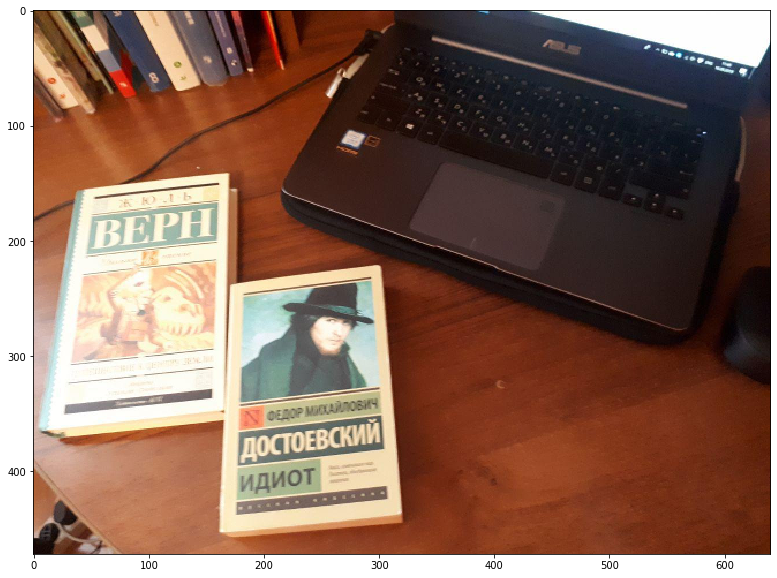

In [ ]:
book_scene = read_and_resize("book_scene.jpg")
plt.imshow(book_scene)
plt.show()

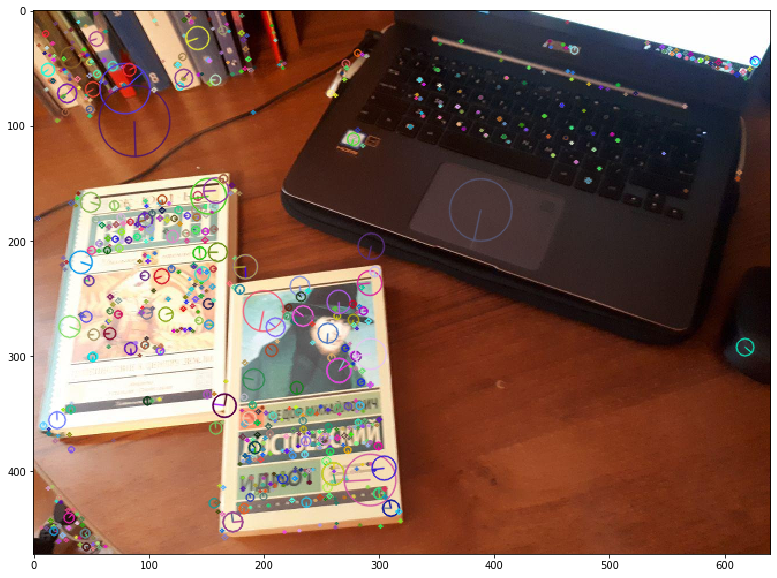

Pos: (3.8406548500061035, 180.36634826660156) 
Size: 3.106300115585327 
Angle: 64.41616821289062
Desc: (128,)


In [ ]:
def processSIFT(img):
  sift = cv2.xfeatures2d.SIFT_create()
  return sift.detectAndCompute(book_scene, None)

kp, descriptors = processSIFT(book_scene)
book_scene_desc = cv2.drawKeypoints(book_scene, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_in_row([book_scene_desc])
print("Pos:",kp[0].pt, "\nSize:", kp[0].size, "\nAngle:", kp[0].angle)
print("Desc:", descriptors[0].shape)

In [ ]:
def crop_rect(img, rect, dst_size=(20, 20)):
  center, size, angle = rect[0], rect[1], rect[2]
  center, size = tuple(map(int, center)), tuple(map(int, size))

  height, width = img.shape[0], img.shape[1]

  M = cv2.getRotationMatrix2D(center, angle, dst_size[0] / size[0])
  img_rot = cv2.warpAffine(img, M, (width, height))

  img_crop = cv2.getRectSubPix(img_rot, dst_size, center)
  return img_crop


def visualize_hist(vec, height = 100, bin_width = 3, divider = None):
  img = np.zeros((height, bin_width * len(vec)), dtype='uint8')
  if divider is None: divider = np.max(vec)
#   print(divider)
  for idx, val in enumerate(vec):
    val = math.ceil(val * height / divider)
    if val > 0: img[-val:, idx*bin_width:(idx+1)*bin_width] = 255
  return img


def get_kp_img(img, k):
  return crop_rect(img, (k.pt, (2*k.size, 2*k.size), k.angle))
  

def show_key_point_and_hist(img, key_points, descs):
  img_list = []
  hist_list = []
  info_list = []
  for idx, k in enumerate(key_points):
    cimg = get_kp_img(img, k)
    img_list.append(cimg)
    hist_img = visualize_hist(descs[idx], height = 300, divider = 200)
    hist_list.append(hist_img)
    info_list.append(str(math.ceil(k.size)))
  show_in_row(img_list, info_list, True)
  show_in_row(hist_list, info_list, True)
 
from_idx = 0
to_idx = from_idx+20
show_key_point_and_hist(book_scene, kp[from_idx:to_idx], descriptors[from_idx:to_idx])

# plt.plot(descriptors[0])
# plt.show()

## Implement vector distance metric
From slides:
![alt text](https://drive.google.com/uc?export=view&id=1sggfpcQvkbkYnIrQ50EcMvRso4VLekL6)

In [ ]:
def euclid_dist(v1, v2):
  diff = v1 - v2
  return np.sum(diff ** 2) ** 0.5

def cosine_dist(v1, v2):
  # TODO
  return None

for i in range(1, 5):
  d1 = euclid_dist(descriptors[i-1], descriptors[i])
  d2 = cosine_dist(descriptors[i-1], descriptors[i])
  print("Euclid1: ", d1, "Cosine2: ", d2)

Euclid1:  367.3526915649319 Cosine2:  0.25763368606567383
Euclid1:  560.4507114813933 Cosine2:  0.5996853709220886
Euclid1:  469.09487313335666 Cosine2:  0.4194296598434448
Euclid1:  555.9352480280414 Cosine2:  0.5887491703033447


In [ ]:
def find_closest_idx(desc, idx, metric):
  # TODO
  return ?

def show_keypoints(kp, descs, indexes):
  show_in_row([get_kp_img(book_scene, kp[i]) for i in indexes], [str(i) for i in indexes])
  show_in_row([visualize_hist(descriptors[i], height = 300, divider = 200) for i in indexes], [str(i) for i in indexes])

def show_closest_keypoints(kp, descs, idx):
  idx_euclid = find_closest_idx(descriptors, idx, euclid_dist)
  idx_cos = find_closest_idx(descriptors, idx, cosine_dist)

  indexes = [idx, idx_euclid, idx_cos]
  show_keypoints(kp, descs, indexes)

  
show_closest_keypoints(kp, descriptors, 0)

# KMean clustering
![alt text](http://mnemstudio.org/ai/cluster/images/k-means1.gif)

1) Initalize centroids at random points<br>
2) Assign points to closest centroid<br>
3) Move centroids to avg value of its points<br>
4) Repeat steps 2-3 N times<br>
5) Profit<br>

In [ ]:
# TODO
def find_closest_idx(descriptors, desc, metric):
  # TODO
  return ?

def kmeans(descriptors, clusters_count, metric, iterations = 50, ):
  # returns list of clustered point indexes
  # return list(list(int))
  
  # step 1
  clusters = descriptors[:clusters_count] 
  clusters_indexes = [[] for _ in range(clusters_count)]
  
  for iter_idx in tqdm(range(iterations), desc="iteration"):  
    # step 2
    ???
    
    #step 3
    ???
  
  return clusters_indexes

clusters = kmeans(descriptors, 100, cosine_dist, 30)

show_keypoints(kp, descriptors, clusters[0][:10])

iteration: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


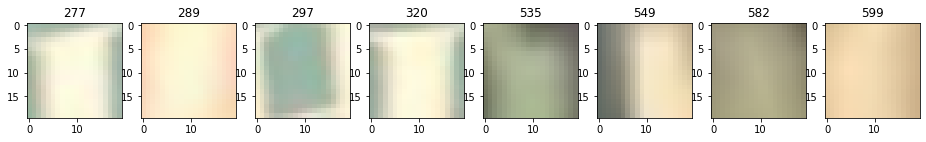

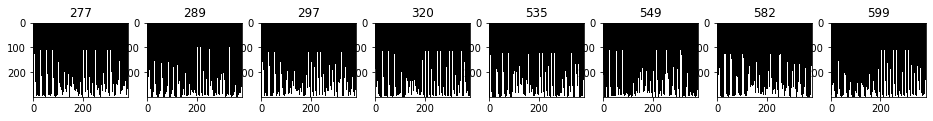

In [ ]:
show_keypoints(kp, descriptors, clusters[23][:10])